In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the hyperparameter-optimised values.

In [3]:
# Author's Original Model: 3 layers, 120 filters per layer, filter length 8, 40 nodes in the dense layer
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                     dropout2=0,dropout3=0.2)

In [4]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

W0918 10:48:53.629008 4711683520 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 10:48:53.682548 4711683520 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 10:48:53.698601 4711683520 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 10:48:53.888855 4711683520 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0918 10:48:53.909473 4711683520 deprecati

In [5]:
# Quick Test of Model Efficacy
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


# Y-Randomization

### Test Same Model Training Schema with Permuted Data Labels

Reassign the MRL labels for the training sequences and then train the model again, see how much worse (or not!) it gets

In [7]:
np.random.seed(1337)
real_train_labels = e_train['scaled_rl'].values
permuted_train_labels = real_train_labels.copy()
np.random.shuffle(permuted_train_labels)
real_test_labels = e_test['scaled_rl'].values
permuted_test_labels = real_test_labels.copy()
np.random.shuffle(permuted_test_labels)

e_train.loc[:,'permuted_rl'] = permuted_train_labels
e_test.loc[:,'permuted_rl'] = permuted_test_labels

#### Does the Authors' trained model work on permuted test set labels?

In [8]:
e_test = test_data(df=e_test, model=model, obs_col='permuted_rl',test_seq=seq_e_test, output_col='permuted_pred')
r = r2(e_test['permuted_rl'], e_test['permuted_pred'])
print 'author model on y-randomized test set, r-squared = ', r

author model on y-randomized test set, r-squared =  4.7229979463729616e-05


Nope, that is a really low R2. Doesn't seem like it works too well. Good!

#### If we train the same structure as the Authors' model on permuted data, can it still get good results?

In [9]:
model_permuted = keras.models.load_model('./saved_models/permuted_main_MRL_model.hdf5')

In [10]:
# np.random.seed(42) #different random seed from the one used to shuffle the values, because paranoid
# model_permuted = train_model(seq_e_train, e_train['permuted_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                     dropout2=0,dropout3=0.2)

In [10]:
# # Save permuted model
# model_permuted.save('./saved_models/permuted_main_MRL_model.hdf5')

In [11]:
# test model trained on permuted data on the real test set
e_test = test_data(df=e_test, model=model_permuted, obs_col='rl',test_seq=seq_e_test,output_col='permuted_model_pred')
r = r2(e_test['rl'], e_test['permuted_model_pred'])
print 'model trained on y-randomized set, real test set r-squared = ', r
# ...and just for fun, test it on the permuted test set
e_test = test_data(df=e_test, model=model_permuted, obs_col='permuted_rl',
                       test_seq=seq_e_test,output_col='permuted_model_permuted_pred')
r = r2(e_test['permuted_rl'], e_test['permuted_model_permuted_pred'])
print 'model trained on y-randomized set, y-randomized test set r-squared = ', r

model trained on y-randomized set, real test set r-squared =  0.0
model trained on y-randomized set, y-randomized test set r-squared =  0.0


This is also a pretty bad R2, so I think we can rest assured that the amount of memorization that a model of their structure can accomplish in the number of epochs they used is not enough to account for more than a negligible fraction of their results.

# Scramble Sequence Content

Repeat the above tests, using the same seq-label pairs but with the bps of every sequence rearranged. Relative ATGC amounts should be the same, but motifs should be destroyed.

In [12]:
np.random.seed(1337)
real_train_utrs = e_train['utr'].values
e_train.loc[:,'scrambled_utr'] = [ "".join(random.sample(s,len(s))) for s in real_train_utrs ]
real_test_utrs = e_test['utr'].values
e_test.loc[:,'scrambled_utr'] = [ "".join(random.sample(s,len(s))) for s in real_test_utrs ]

seq_e_train_scramble = one_hot_encode(e_train,seq_len=50,col='scrambled_utr')
seq_e_test_scramble = one_hot_encode(e_test,seq_len=50,col='scrambled_utr')

#### Does the Authors' trained model work on shuffled sequence content?

In [13]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test_scramble, output_col='shuffled_pred')
r = r2(e_test['rl'], e_test['shuffled_pred'])
print 'r-squared = ', r

r-squared =  0.0015519581480485057


This does work better than it did in the Y-Randomization test, but still not well at all

#### If we train the same structure as the Authors' model on shuffled sequences, can it still get good results?

In [14]:
model_scrambled = keras.models.load_model('./saved_models/scrambled_main_MRL_model.hdf5')

In [15]:
# np.random.seed(42) #different random seed from the one used to shuffle the values, because paranoid
# model_scrambled = train_model(seq_e_train_scramble, e_train['rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                     dropout2=0,dropout3=0.2) 

In [16]:
# Save permuted model
# model_scrambled.save('./saved_models/scrambled_main_MRL_model.hdf5')

In [17]:
# test model trained on scrambled data on the real test set
e_test = test_data(df=e_test, model=model_scrambled, obs_col='rl',
                    test_seq=seq_e_test,output_col='shuffled_model_pred')
r = r2(e_test['rl'], e_test['shuffled_model_pred'])
print 'r-squared = ', r
# ...and just for fun, test it on the scrambled test set
e_test = test_data(df=e_test, model=model_scrambled, obs_col='rl',
                    test_seq=seq_e_test_scramble,output_col='shuffled_model_shuffled_pred')
r = r2(e_test['rl'], e_test['shuffled_model_shuffled_pred'])
print 'r-squared = ', r

r-squared =  0.04644400991399701
r-squared =  0.04390505752467938


Well, clearly it's possible to learn something--which makes sense, GC content is usually correlated with literally everything--but this is still an r-squared below 0.1, so it is definitely not that good.

## Visualize Performance

In [18]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
print "Number of utrs with ATG:", len(atg)
print "Number of utrs without ATG:", len(n_atg)

Number of utrs with ATG: 13986
Number of utrs without ATG: 6014


Text(0.5,0.98,'Author Model on Sequence-Scrambled Test Set')

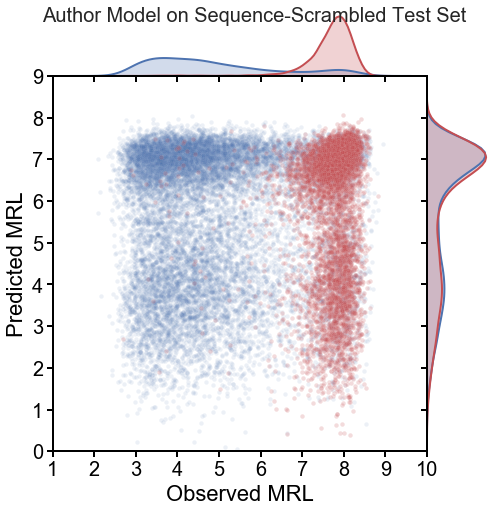

In [23]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="shuffled_pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});
g.x = n_atg['rl'].values
g.y = n_atg['shuffled_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
f.suptitle("Author Model on Sequence-Scrambled Test Set",fontsize=20)

## Yep, that's bad! Great. 

Text(0.5,0.98,'Scrambled-Sequence-Trained Model on Real Test Set')

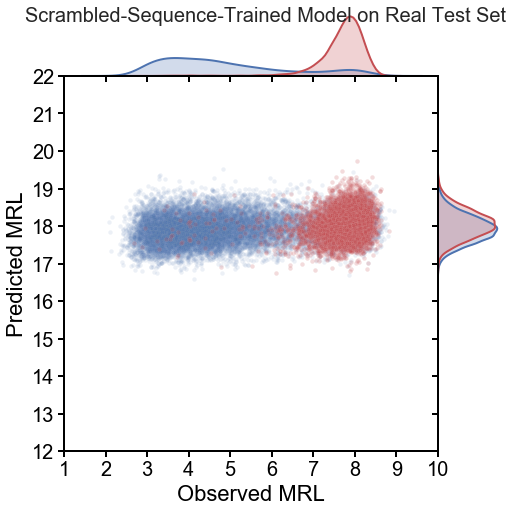

In [35]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="shuffled_model_pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(12,22.01, 1));
ax.set_yticklabels(range(12,23),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(12,22)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});
g.x = n_atg['rl'].values
g.y = n_atg['shuffled_model_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
f.suptitle("Scrambled-Sequence-Trained Model on Real Test Set",fontsize=20)

## Also quite bad! Excellent. 